<a href="https://colab.research.google.com/github/debo-6186/bank_transaction_fraud_detector/blob/main/hackathon_networkx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y nvidia-cublas-cu12
!pip install nvidia-cublas-cu12==12.4.5.8
!pip install nx_arangodb
!pip install arango_datasets

Found existing installation: nvidia-cublas-cu12 12.5.3.2
Uninstalling nvidia-cublas-cu12-12.5.3.2:
  Successfully uninstalled nvidia-cublas-cu12-12.5.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 which is incompatible.
torch 2.5.1+cu124 re

In [2]:
!nvidia-smi
!nvcc --version

Sun Mar  9 14:08:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# !nvcc --version
!pip install nx-cugraph-c12 --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
ERROR: Could not find a version that satisfies the requirement nx-cugraph-c12 (from versions: none)
ERROR: No matching distribution found for nx-cugraph-c12


In [4]:
!pip install --upgrade langchain langchain-community langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.40
    Uninstalling langchain-core-0.3.40:
      Successfully uninstalled langchain-core-0.3.40
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.19
    Uninstalling langchain-0.3.19:
      Successfully uninstalled langchain-0.3.19


In [5]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

[14:09:38 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [6]:
# Data Preparation

import csv
import random
from datetime import datetime, timedelta
import numpy as np

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Generate 100 unique account numbers
account_numbers = []
for i in range(100):
    prefix = random.choice(['103', '609', '812', '916', '475', '235', '701', '888', '555', '777'])
    middle = random.randint(100000, 999999)
    account_numbers.append(f"{prefix}{middle}")

# Create list of plausible transaction descriptions
descriptions = [
    "Monthly Rent Payment", "Salary Deposit", "Grocery Shopping", "Utility Bill Payment",
    "Restaurant Bill", "Online Purchase", "Transfer to Family", "Insurance Premium",
    "Investment Deposit", "ATM Withdrawal", "Loan Repayment", "Mobile Phone Bill",
    "Internet Service", "Medical Expenses", "Car Payment", "Entertainment",
    "Home Repair", "Education Expenses", "Charity Donation", "Travel Booking",
    "Gas/Fuel Purchase", "Clothing Purchase", "Subscription Service", "Tax Payment",
    "Dividend Payment", "Consulting Fee", "Business Supplies", "Office Rent",
    "Legal Services", "Accounting Services"
]

person_names = [
    "John Smith", "Mary Johnson", "Robert Lee", "Patricia Wong", "Michael Chen",
    "Linda Kumar", "James Rodriguez", "Elizabeth Taylor", "David Kim", "Jennifer Tan",
    "Richard Santos", "Susan Lim", "Joseph Patel", "Margaret Singh", "Thomas Nguyen",
    "Barbara Ali", "Charles Gomez", "Jessica Li", "Daniel Sharma", "Sarah Abdullah",
    "Anthony Cruz", "Nancy Zhang", "Mark Garcia", "Lisa Ahmad", "Donald Fernandez",
    "Helen Wu", "Paul Martinez", "Sandra Das", "George Gupta", "Karen Hassan"
]

# Set date range
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 2, 28)

# Helper function to generate a random date within range
def random_date():
    delta = (end_date - start_date).days
    random_days = random.randint(0, delta)
    return start_date + timedelta(days=random_days)

# Helper function to format date
def format_date(date):
    return date.strftime("%d/%m/%Y")

# Helper function to parse formatted date back to datetime
def parse_date(date_str):
    return datetime.strptime(date_str, "%d/%m/%Y")

# Helper function to create a transfer description
def transfer_description():
    choice = random.randint(1, 3)
    if choice == 1:
        return f"Transfer to {random.choice(person_names)}"
    elif choice == 2:
        return f"Payment to {random.choice(person_names)}"
    else:
        return f"Transfer to {random.choice(descriptions)}"

# Create circular patterns (5 sets)
circular_patterns = []

# Pattern 1: 2-hop cycle
c1_accounts = random.sample(account_numbers, 2)
c1_amount = random.randint(5000, 15000)
c1_date1 = random_date()
c1_date2 = c1_date1 + timedelta(days=random.randint(1, 3))
circular_patterns.extend([
    [c1_accounts[0], c1_accounts[1], format_date(c1_date1), f"Transfer to {random.choice(person_names)}", c1_amount, ""],
    [c1_accounts[1], c1_accounts[0], format_date(c1_date2), f"Transfer to {random.choice(person_names)}", c1_amount, ""]
])

# Pattern 2: 3-hop cycle
c2_accounts = random.sample(account_numbers, 3)
c2_amount = random.randint(7000, 12000)
c2_date1 = random_date()
c2_date2 = c2_date1 + timedelta(days=random.randint(1, 2))
c2_date3 = c2_date2 + timedelta(days=random.randint(1, 2))
circular_patterns.extend([
    [c2_accounts[0], c2_accounts[1], format_date(c2_date1), f"Transfer to {random.choice(person_names)}", c2_amount, ""],
    [c2_accounts[1], c2_accounts[2], format_date(c2_date2), f"Transfer to {random.choice(person_names)}", c2_amount, ""],
    [c2_accounts[2], c2_accounts[0], format_date(c2_date3), f"Transfer to {random.choice(person_names)}", c2_amount, ""]
])

# Pattern 3: 4-hop cycle
c3_accounts = random.sample(account_numbers, 4)
c3_amount = random.randint(8000, 20000)
c3_date1 = random_date()
c3_date2 = c3_date1 + timedelta(days=random.randint(1, 2))
c3_date3 = c3_date2 + timedelta(days=random.randint(1, 2))
c3_date4 = c3_date3 + timedelta(days=random.randint(1, 2))
circular_patterns.extend([
    [c3_accounts[0], c3_accounts[1], format_date(c3_date1), f"Transfer to {random.choice(person_names)}", c3_amount, ""],
    [c3_accounts[1], c3_accounts[2], format_date(c3_date2), f"Transfer to {random.choice(person_names)}", c3_amount, ""],
    [c3_accounts[2], c3_accounts[3], format_date(c3_date3), f"Transfer to {random.choice(person_names)}", c3_amount, ""],
    [c3_accounts[3], c3_accounts[0], format_date(c3_date4), f"Transfer to {random.choice(person_names)}", c3_amount, ""]
])

# Pattern 4: 3-hop cycle with slightly varying amounts
c4_accounts = random.sample(account_numbers, 3)
c4_base_amount = random.randint(10000, 25000)
c4_amounts = [c4_base_amount, c4_base_amount - random.randint(100, 300), c4_base_amount - random.randint(400, 600)]
c4_date1 = random_date()
c4_date2 = c4_date1 + timedelta(days=random.randint(1, 2))
c4_date3 = c4_date2 + timedelta(days=random.randint(1, 2))
circular_patterns.extend([
    [c4_accounts[0], c4_accounts[1], format_date(c4_date1), f"Transfer to {random.choice(person_names)}", c4_amounts[0], ""],
    [c4_accounts[1], c4_accounts[2], format_date(c4_date2), f"Transfer to {random.choice(person_names)}", c4_amounts[1], ""],
    [c4_accounts[2], c4_accounts[0], format_date(c4_date3), f"Transfer to {random.choice(person_names)}", c4_amounts[2], ""]
])

# Pattern 5: 4-hop cycle with exactly the same amount (most suspicious)
c5_accounts = random.sample(account_numbers, 4)
c5_amount = random.randint(30000, 50000)
c5_date1 = random_date()
c5_date2 = c5_date1 + timedelta(days=1)
c5_date3 = c5_date2 + timedelta(days=1)
c5_date4 = c5_date3 + timedelta(days=1)
circular_patterns.extend([
    [c5_accounts[0], c5_accounts[1], format_date(c5_date1), "Investment Transfer", c5_amount, ""],
    [c5_accounts[1], c5_accounts[2], format_date(c5_date2), "Business Investment", c5_amount, ""],
    [c5_accounts[2], c5_accounts[3], format_date(c5_date3), "Capital Transfer", c5_amount, ""],
    [c5_accounts[3], c5_accounts[0], format_date(c5_date4), "Return on Investment", c5_amount, ""]
])

# Generate remaining normal transactions
regular_transactions = []
remaining_count = 600 - len(circular_patterns)

for _ in range(remaining_count):
    source = random.choice(account_numbers)
    dest = random.choice([acc for acc in account_numbers if acc != source])

    date = format_date(random_date())

    # Randomly decide if it's credit or debit
    is_credit = random.random() < 0.4

    amount = random.randint(50, 5000) if random.random() < 0.8 else random.randint(5001, 50000)

    if is_credit:
        debit = ""
        credit = amount
        desc = random.choice([
            f"Salary from {random.choice(['ABC Corp', 'XYZ Inc', 'Tech Solutions', 'Global Services', 'United Group'])}",
            f"Refund for {random.choice(descriptions)}",
            f"Payment from {random.choice(person_names)}",
            f"Interest Income",
            f"Dividend Payment"
        ])
    else:
        debit = amount
        credit = ""
        desc = transfer_description()

    regular_transactions.append([source, dest, date, desc, debit, credit])

# Combine all transactions
all_transactions = circular_patterns + regular_transactions
print(len(all_transactions))

# Sort transactions by date
all_transactions.sort(key=lambda x: parse_date(x[2]))

# Create CSV file
with open('transactions.csv', 'w', newline='') as file:
    print("Writing to file")
    writer = csv.writer(file)
    writer.writerow(['Source Account Number', 'Destination Account Number', 'Date', 'Description', 'Debit', 'Credit'])
    writer.writerows(all_transactions)

600
Writing to file


In [7]:
import pandas as pd
import networkx as nx
from arango import ArangoClient
import datetime

# Read the CSV file with bank transactions
df = pd.read_csv('./transactions.csv')

# Display the first few rows to verify data
# print(df.head())

# Create a directed graph
G = nx.DiGraph()

# Process each transaction and add to graph
for idx, row in df.iterrows():
    source = "account_" + str(row['Source Account Number'])
    target = "account_" + str(row['Destination Account Number'])
    date = row['Date']
    description = row['Description']

    # Determine transaction amount (either Debit or Credit)
    if pd.notna(row['Debit']):
        amount = row['Debit']
        transaction_type = 'Debit'
    else:
        amount = row['Credit']
        transaction_type = 'Credit'

    # Add nodes if they don't exist
    if not G.has_node(source):
        G.add_node(source, account_type='Account', original_id=source)

    if not G.has_node(target):
        G.add_node(target, account_type='Account', original_id=target)

    # Add edge with transaction details
    G.add_edge(
        source,
        target,
        date=date,
        description=description,
        amount=float(amount),
        transaction_type=transaction_type
    )
print(G.nodes())
print(G.edges(data=True))

# Print some basic info about the graph
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

['account_475246413', 'account_475883300', 'account_475263032', 'account_777439902', 'account_812575763', 'account_701725380', 'account_555308496', 'account_777518801', 'account_555887352', 'account_609738720', 'account_475905934', 'account_888766563', 'account_609126225', 'account_235322955', 'account_475183667', 'account_777127824', 'account_555191161', 'account_235472528', 'account_916205907', 'account_103340174', 'account_235520651', 'account_555738551', 'account_888195325', 'account_475624902', 'account_609814825', 'account_235216970', 'account_916629903', 'account_475982554', 'account_609809570', 'account_916802729', 'account_916881177', 'account_555539898', 'account_777542417', 'account_103131244', 'account_235899550', 'account_609148050', 'account_916900581', 'account_475356787', 'account_916910620', 'account_812660086', 'account_812832052', 'account_235733052', 'account_812634277', 'account_916694731', 'account_475969693', 'account_701724834', 'account_916571029', 'account_777

In [8]:
# 6. Connect to the ArangoDB database
# TODO: Configure your credentials here!

client = ArangoClient(hosts="https://600614b0e1e6.arangodb.cloud:8529")
db = client.db(username="root", password="<my_password>")

print(db)

<StandardDatabase _system>


In [9]:
# 1. Load the NetworkX Graph into ArangoDB
# Reference: https://github.com/arangodb/nx-arangodb?tab=readme-ov-file#can-i-create-an-arangodb-graph-from-an-existing-networkx-graph

G_adb = nxadb.Graph(
    name="bank_transactions_latest",
    db=db,
    incoming_graph_data=G,
    write_batch_size=50000, # feel free to modify
    overwrite_graph=True
)

print(G_adb)

[14:09:59 +0000] [INFO]: Overwriting graph 'bank_transactions_latest'
INFO:nx_arangodb:Overwriting graph 'bank_transactions_latest'
[14:09:59 +0000] [INFO]: Graph 'bank_transactions_latest' exists.
INFO:nx_arangodb:Graph 'bank_transactions_latest' exists.
[14:10:00 +0000] [INFO]: Default node type set to 'bank_transactions_latest_node'
INFO:nx_arangodb:Default node type set to 'bank_transactions_latest_node'
[2025/03/09 14:10:01 +0000] [280] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/09 14:10:03 +0000] [280] [INFO] - adbnx_adapter: Created ArangoDB 'bank_transactions_latest' Graph
INFO:adbnx_adapter:Created ArangoDB 'bank_transactions_latest' Graph


Graph named 'bank_transactions_latest' with 100 nodes and 581 edges


In [10]:
import os

os.environ["OPENAI_API_KEY"] = "<my_key>"
llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-1cca5bcd-8283-42cd-9684-ae4554398fc0-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [11]:
arango_graph = ArangoGraph(db)

In [12]:
from langchain.chains import GraphCypherQAChain
from langchain.chat_models import ChatOpenAI
model = ChatOpenAI(temperature=0, model_name="gpt-4o")

chain = ArangoGraphQAChain.from_llm(
    llm=model,
    graph=arango_graph,
    verbose=True,
    allow_dangerous_requests=True
)

<ipython-input-12-f86c93dba797>:3: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  model = ChatOpenAI(temperature=0, model_name="gpt-4o")


In [13]:
chain.invoke("Show the 1 hop connections of account 40")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH bank_transactions_node, bank_transactions_node_to_bank_transactions_node
FOR v, e IN 1..1 ANY CONCAT('bank_transactions_node/', '40') bank_transactions_node_to_bank_transactions_node
RETURN {vertex: v, edge: e}

AQL Result:
[{'vertex': {'_key': '84', '_id': 'bank_transactions_node/84', '_rev': '_jVlXnbu-_S', 'account_type': 'Account'}, 'edge': {'_key': '492', '_id': 'bank_transactions_node_to_bank_transactions_node/492', '_from': 'bank_transactions_node/84', '_to': 'bank_transactions_node/40', '_rev': '_jVlXnoi-_H', 'date': '19/01/2025', 'description': 'Interest Income', 'amount': 3730, 'transaction_type': 'Credit'}}, {'vertex': {'_key': '39', '_id': 'bank_transactions_node/39', '_rev': '_jVlXnbu--l', 'account_type': 'Account'}, 'edge': {'_key': '233', '_id': 'bank_transactions_node_to_bank_transactions_node/233', '_from': 'bank_transactions_node/39', '_to': 'bank_transactions_node/40', '_rev': '_jVlXnoW--7', 'date': '03/

{'query': 'Show the 1 hop connections of account 40',
 'result': 'The account with ID 40 has several one-hop connections with other accounts. Here are the details of these connections:\n\n1. Account 84 credited account 40 with an amount of 3730 on 19/01/2025, described as "Interest Income."\n2. Account 39 debited account 40 with an amount of 4751 on 03/01/2025, described as "Payment to Paul Martinez."\n3. Account 36 credited account 40 with an amount of 4450 on 03/01/2025, described as "Refund for Grocery Shopping."\n4. Account 11 debited account 40 with an amount of 3282 on 06/02/2025, described as "Payment to Donald Fernandez."\n5. Account 5 credited account 40 with an amount of 2197 on 30/01/2025, described as "Payment from Paul Martinez."\n6. Account 0 debited account 40 with an amount of 4866 on 19/02/2025, described as "Transfer to Mobile Phone Bill."\n7. Account 40 credited account 56 with an amount of 265 on 20/02/2025, described as "Payment from Daniel Sharma."\n8. Account 40 

In [14]:
@tool
def text_to_aql_to_text(query: str):
  """
  This tool is available to invoke the
  ArangoGraphQAChain object, which enables you to
  translate a Natural Language Query into AQL, execute
  the query, and translate the result back into Natural language
  """
  llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
  chain = ArangoGraphQAChain.from_llm(
      llm=llm,
      graph=arango_graph,
      verbose=True,
      allow_dangerous_requests=True
  )
  result = chain.invoke(query)
  return str(result["result"])

In [15]:
import re
import networkx as nx
from typing import Any
from openai import OpenAI
from functools import wraps

def tool(func):
  @wraps(func)
  def wrapper(*args, **kwargs):
    return func(*args, **kwargs)
  return wrapper

@tool
def text_to_nx_algorithm_to_text(query: str):
  print("Generating NetworkX code from query...")

  text_to_nx = llm.chat.completions.create(
    messages=[
        {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
        {"role": "user", "content": f"""
  I have a NetworkX Graph object named `G` representing a bank transactions.
  - Nodes represent accounts
  -- Example ('Account_60', 'Account_150'), (graph example: {'_key': '80', '_id': 'bank_transactions_latest_node/80', '_rev': '_jVmqqUK-_O', 'account_type': 'Account', 'original_id': 'account_888662275'})
  - Edges represent the transactions between different accounts. (example: ('account_777479201', 'account_475263032', {'date': '20/01/2025', 'description': 'Payment to Lisa Ahmad', 'amount': 2678.0, 'transaction_type': 'Debit'})).

  Here is the query to solve: "{query}"

  Generate the appropriate Python code using NetworkX to answer this query.

  Instructions:
  - Use the `G` object.
  - Choose the most suitable NetworkX algorithm.
  - The final answer must be stored in a variable named `FINAL_RESULT`.
  - Provide only executable code without comments or explanations.
  """}
      ]
  ).choices[0].message.content.strip()

  code_block = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

  print("-"*10)
  print("Generated Code:")
  print(code_block)
  print("-"*10)

  print("Executing Generated NetworkX Code...")
  global_vars = {"G": G, "nx": nx}
  local_vars = {}
  try:
    exec(code_block, global_vars, local_vars)
    text_to_nx_final = text_to_nx
  except Exception as e:
    print(f"Error executing generated code: {e}")
    return f"Error executing generated code: {e}"

  print("-"*10)
  FINAL_RESULT = local_vars.get("FINAL_RESULT")
  print(f"Final Result: {FINAL_RESULT}")
  print("-" * 10)

  print("\n3) Formulating final natural language response...")
  nx_to_text = llm.chat.completions.create(
    messages=[
        {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
        {"role": "user", "content": f"""
        I executed the following python code to answer the query "{query}":
        ```python
        {code_block}
        ```
        The FINAL_RESULT is: {FINAL_RESULT}

        Provide a clear and consise explanation for the user based on the original query and the result.
        """}
    ]).choices[0].message.content.strip()

  print("Final Response: ", nx_to_text)
  return nx_to_text

In [16]:
# 6. Create the Agentic Application

# Note: Consider implementing a hybrid tool that combines both AQL & NetworkX Algorithms!

tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text]

def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [18]:
import re
import networkx as nx
from functools import wraps
from langchain.chat_models import ChatOpenAI
from langchain.agents import initialize_agent, AgentType, Tool
from langchain.schema import SystemMessage, HumanMessage

def tool(func):
  @wraps(func)
  def wrapper(*args, **kwargs):
    return func(*args, **kwargs)
  # attach attributes required by the agent
  wrapper.is_single_input = True
  wrapper.name = func.__name__
  wrapper.description = func.__doc__ or ""
  return wrapper

@tool
def text_to_aql_to_text(query: str):
    """
    This tool invokes the ArangoGraphQAChain to:
    1. Translate a natural language query into AQL.
    2. Execute the query against an ArangoDB graph.
    3. Return the result in natural language.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    result = chain.invoke(query)
    return str(result["result"])

@tool
def text_to_nx_algorithm_to_text(query: str) -> str:
    """
    Agentic AI Tool:
    Translates a natural language query into a NetworkX algorithm,
    executes it on a flight network graph, and returns a concise explanation.
    """
    print("1) Generating NetworkX code from query...")
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    text_to_nx = llm(
        [
            SystemMessage(content="You are an expert in graph algorithms using NetworkX."),
            HumanMessage(content=f"""
I have a NetworkX Graph object named `G` representing a bank transactions.
  - Nodes represent accounts
  -- Example ('Account_60', 'Account_150'), (graph example: {'_key': '80', '_id': 'bank_transactions_latest_node/80', '_rev': '_jVmqqUK-_O', 'account_type': 'Account', 'original_id': 'account_888662275'})
  - Edges represent the transactions between different accounts.
  -- Example: ('account_777479201', 'account_475263032', {'date': '20/01/2025', 'description': 'Payment to Lisa Ahmad', 'amount': 2678.0, 'transaction_type': 'Debit'})).

Here is the query to solve: "{query}"

Generate the appropriate Python code using NetworkX to answer this query.

Instructions:
- Use the `G` object.
- Choose the most suitable NetworkX algorithm.
- The final answer must be stored in a variable named `FINAL_RESULT`.
- Provide only executable code without comments or explanations.
"""),
        ]
    ).content.strip()

    # Remove code block markers if present
    code_block = re.sub(r"```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-' * 10)
    print("Generated Code:")
    print(code_block)
    print('-' * 10)

    print("\n2) Executing the generated NetworkX code...")
    global_vars = {"G": G, "nx": nx}
    local_vars = {}
    try:
        exec(code_block, global_vars, local_vars)
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

    print('-' * 10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL RESULT: {FINAL_RESULT}")
    print('-' * 10)

    print("\n3) Formulating final natural language response...")
    nx_to_text = llm(
        [
            SystemMessage(content="You are an expert at interpreting NetworkX graph results."),
            HumanMessage(content=f"""
I executed the following Python code to answer the query "{query}":

---
{code_block}
---

The `FINAL_RESULT` is: {FINAL_RESULT}

Provide a clear and concise explanation for the user based on the original query and the result.
"""),
        ]
    ).content.strip()

    print("Final Response:", nx_to_text)
    return nx_to_text

# List of available tools
tools = [
    Tool(
        name=text_to_aql_to_text.__name__,
        func=text_to_aql_to_text,
        description=text_to_aql_to_text.__doc__
    ),
    Tool(
        name=text_to_nx_algorithm_to_text.__name__,
        func=text_to_nx_algorithm_to_text,
        description=text_to_nx_algorithm_to_text.__doc__
    )
]

def query_graph(query: str) -> str:
    print("Entering query_graph")
    """
    Initializes an agent with the available tools and runs the query.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)
    response = agent.run(query)
    return response

# Example usage:
# result = query_graph("which protein is the most connected in the network?")
# print(result)

In [19]:
query_graph("Which account has done transactions with maximum accounts?")

Entering query_graph


> Entering new AgentExecutor chain...


<ipython-input-18-67c6c35399eb>:131: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(tools, llm, agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION, verbose=True)
<ipython-input-18-67c6c35399eb>:132: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent.run(query)


To determine which account has done transactions with the maximum number of other accounts, I need to analyze the transaction data in the graph database. This requires querying the graph to find the account with the highest number of unique transaction partners.

Action: text_to_aql_to_text
Action Input: "Find the account that has done transactions with the maximum number of other accounts."

> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH bank_transactions_latest_node, bank_transactions_latest_node_to_bank_transactions_latest_node
FOR account IN bank_transactions_latest_node
    LET transactionCount = LENGTH(
        FOR transaction IN bank_transactions_latest_node_to_bank_transactions_latest_node
            FILTER transaction._from == account._id
            COLLECT otherAccount = transaction._to
            RETURN otherAccount
    )
    SORT transactionCount DESC
    LIMIT 1
    RETURN {
        account: account,
        transactionCount: transactionCount
    }

AQL 

'The account that has done transactions with the maximum number of other accounts is `account_475835911`, which has engaged in transactions with 13 different accounts.'

In [29]:
!export NETWORKX_AUTOMATIC_BACKENDS=cugraph
!%set_env NETWORKX_AUTOMATIC_BACKENDS=cugraph

import re
import networkx as nx
from typing import Any
from openai import OpenAI  # Replace with your LLM integration if different
from functools import wraps

# Updated tool decorator that preserves docstrings
def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    # Add the necessary attributes that LangChain expects
    wrapper.is_single_input = True
    wrapper.name = func.__name__
    wrapper.description = func.__doc__
    wrapper.args_schema = None  # You could set a schema if needed

    return wrapper

# -------------------
# Text-to-AQL Tool
# -------------------

@tool
def text_to_aql_to_text(query: str) -> str:
    """
    This tool is available to invoke the ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute the query, and translate the result
    back into Natural Language.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    result = chain.invoke(query)
    return str(result["result"])

# -------------------
# Text-to-NetworkX Algorithm Tool
# -------------------

@tool
def text_to_nx_algorithm_to_text(query: str) -> str:
    """
    Agentic AI Tool:
    Translates natural language queries into NetworkX algorithms, executes them,
    and returns concise answers based on the drug similarity dataset.
    """
    print("1) Generating NetworkX code from query...")

    text_to_nx = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": f"""
- Nodes represent accounts
  -- Example ('Account_60', 'Account_150'), (graph example: {{'_key': '80', '_id': 'bank_transactions_latest_node/80', '_rev': '_jVmqqUK-_O', 'account_type': 'Account', 'original_id': 'account_888662275'}})
  - Edges represent the transactions between different accounts.
  -- Example: ('account_777479201', 'account_475263032', {{'date': '20/01/2025', 'description': 'Payment to Lisa Ahmad', 'amount': 2678.0, 'transaction_type': 'Debit'}})).
  -- Each edge has an amount value either as debit or credit.

Here is the query to solve: "{query}"

Generate the appropriate NetworkX code to answer this query.

Instructions:
- Use the `G` object.
- Choose the most suitable NetworkX algorithm.
- If relevant, use the `similarity_score` edge attribute.
- The final answer must be stored in a variable named `FINAL_RESULT`.
- Provide only executable code without comments or explanations.
"""}
]).content.strip()

    # Remove any code block markers
    code_block = re.sub(r"```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-' * 10)
    print("Generated Code:")
    print(code_block)
    print('-' * 10)

    print("\n2) Executing the generated NetworkX code...")
    global_vars = {"G": G, "nx": nx}
    local_vars = {}

    try:
        exec(code_block, global_vars, local_vars)
        FINAL_RESULT = local_vars["FINAL_RESULT"]
    except Exception as e:
        print(f"Execution Error: {e}")
        return f"Execution Error: {e}"

    print('-' * 10)
    print(f"Execution Result: {FINAL_RESULT}")
    print('-' * 10)

    print("\n3) Formulating final natural language response...")

    nx_to_text = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": f"""
    I executed the following Python code to answer the query "{query}":

    ---
    {code_block}
    ---

    The `FINAL_RESULT` is: {FINAL_RESULT}

    Provide a clear and concise explanation for the user based on the original query and the result.
    """}
    ]).content.strip()

    print("Final Response:", nx_to_text)
    return nx_to_text

@tool
def text_to_hybrid_query_to_text(query: str) -> str:
    """
    Hybrid Query Tool:
    This tool accepts a natural language query that may require both AQL and NetworkX operations.
    It invokes both the AQL and NetworkX tools, then merges their outputs into a single, concise answer.
    """
    # Instantiate the LLM for merging responses
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    print("Calling AQL tool...")
    aql_response = text_to_aql_to_text(query)
    print("AQL Response:", aql_response)

    print("Calling NetworkX tool...")
    nx_response = text_to_nx_algorithm_to_text(query)
    print("NetworkX Response:", nx_response)

    combined_prompt = f"""
I have received the following responses for the query: "{query}"
AQL response: {aql_response}
NetworkX response: {nx_response}

Combine these responses into one clear and concise answer that best addresses the query.
"""

    hybrid_response = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": combined_prompt}
    ]).content.strip()
    # hybrid_response = llm.chat.completions.create(
    #     messages=[
    #         {"role": "system", "content": "You are an expert at merging multiple graph query responses."},
    #         {"role": "user", "content": combined_prompt}
    #     ]
    # ).choices[0].message.content.strip()

    return hybrid_response

# -------------------------
# Create the Agentic Application
# -------------------------

# Then create Tool objects
tools = [
    Tool(
        name="text_to_aql_to_text",
        func=text_to_aql_to_text,
        description="Translates natural language to AQL queries, executes them, and returns results"
    ),
    Tool(
        name="text_to_nx_algorithm_to_text",
        func=text_to_nx_algorithm_to_text,
        description="Translates natural language into NetworkX graph algorithms and returns results"
    ),
    Tool(
        name="text_to_hybrid_query_to_text",
        func=text_to_hybrid_query_to_text,
        description="Combines AQL and NetworkX to handle complex graph queries"
    )
]

# Dummy implementation of create_react_agent
def create_react_agent(llm, tools):
    # This dummy agent ignores the tools list and always uses the hybrid tool.
    class DummyAgent:
        def invoke(self, input_dict):
            query = input_dict["messages"][-1]["content"]
            # Call the hybrid tool directly
            response = text_to_hybrid_query_to_text(query)
            return {"messages": [{"role": "assistant", "content": response}]}
    return DummyAgent()

# Now you can call query_graph without the NotImplementedError.
result = query_graph("Find cycling transactions in the graph where money flows from A to B, then B to A?")
print(result)

/bin/bash: line 1: fg: no job control
Entering query_graph


> Entering new AgentExecutor chain...
To find cycling transactions where money flows from A to B and then back from B to A, I need to identify cycles in the transaction graph. This involves detecting cycles of length 2 in the graph. I will use a graph algorithm to find these cycles.

Action: text_to_nx_algorithm_to_text
Action Input: "Find cycles of length 2 in the transaction graph where money flows from A to B and then B to A."1) Generating NetworkX code from query...
----------
Generated Code:
import networkx as nx

# Assuming G is already defined and populated with nodes and edges

# Find cycles of length 2
cycles_of_length_2 = [(u, v) for u, v in G.edges() if G.has_edge(v, u)]

FINAL_RESULT = cycles_of_length_2
----------

2) Executing the generated NetworkX code...
----------
Execution Result: [('account_475263032', 'account_609897549'), ('account_701725380', 'account_103340174'), ('account_609738720', 'account_55553989

In [30]:
# 8. (Optional) Set up UI via Gradio

!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
!export NETWORKX_AUTOMATIC_BACKENDS=cugraph
!%set_env NETWORKX_AUTOMATIC_BACKENDS=cugraph

import re
import networkx as nx
from typing import Any
from openai import OpenAI  # Replace with your LLM integration if different
from functools import wraps

# Updated tool decorator that preserves docstrings
def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    # Add the necessary attributes that LangChain expects
    wrapper.is_single_input = True
    wrapper.name = func.__name__
    wrapper.description = func.__doc__
    wrapper.args_schema = None  # You could set a schema if needed

    return wrapper

# -------------------
# Text-to-AQL Tool
# -------------------

@tool
def text_to_aql_to_text(query: str) -> str:
    """
    This tool is available to invoke the ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute the query, and translate the result
    back into Natural Language.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    result = chain.invoke(query)
    return str(result["result"])

# -------------------
# Text-to-NetworkX Algorithm Tool
# -------------------

@tool
def text_to_nx_algorithm_to_text(query: str) -> str:
    """
    Agentic AI Tool:
    Translates natural language queries into NetworkX algorithms, executes them,
    and returns concise answers based on the drug similarity dataset.
    """
    print("1) Generating NetworkX code from query...")

    text_to_nx = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": f"""
- Nodes represent accounts
  -- Example ('Account_60', 'Account_150'), (graph example: {{'_key': '80', '_id': 'bank_transactions_latest_node/80', '_rev': '_jVmqqUK-_O', 'account_type': 'Account', 'original_id': 'account_888662275'}})
  - Edges represent the transactions between different accounts.
  -- Example: ('account_777479201', 'account_475263032', {{'date': '20/01/2025', 'description': 'Payment to Lisa Ahmad', 'amount': 2678.0, 'transaction_type': 'Debit'}})).
  -- Each edge has an amount value either as debit or credit.

Here is the query to solve: "{query}"

Generate the appropriate NetworkX code to answer this query.

Instructions:
- Use the `G` object.
- Choose the most suitable NetworkX algorithm.
- If relevant, use the `similarity_score` edge attribute.
- The final answer must be stored in a variable named `FINAL_RESULT`.
- Provide only executable code without comments or explanations.
"""}
]).content.strip()

    # Remove any code block markers
    code_block = re.sub(r"```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-' * 10)
    print("Generated Code:")
    print(code_block)
    print('-' * 10)

    print("\n2) Executing the generated NetworkX code...")
    global_vars = {"G": G, "nx": nx}
    local_vars = {}

    try:
        exec(code_block, global_vars, local_vars)
        FINAL_RESULT = local_vars["FINAL_RESULT"]
    except Exception as e:
        print(f"Execution Error: {e}")
        return f"Execution Error: {e}"

    print('-' * 10)
    print(f"Execution Result: {FINAL_RESULT}")
    print('-' * 10)

    print("\n3) Formulating final natural language response...")

    nx_to_text = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": f"""
    I executed the following Python code to answer the query "{query}":

    ---
    {code_block}
    ---

    The `FINAL_RESULT` is: {FINAL_RESULT}

    Provide a clear and concise explanation for the user based on the original query and the result.
    """}
    ]).content.strip()

    print("Final Response:", nx_to_text)
    return nx_to_text

@tool
def text_to_hybrid_query_to_text(query: str) -> str:
    """
    Hybrid Query Tool:
    This tool accepts a natural language query that may require both AQL and NetworkX operations.
    It invokes both the AQL and NetworkX tools, then merges their outputs into a single, concise answer.
    """
    # Instantiate the LLM for merging responses
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    print("Calling AQL tool...")
    aql_response = text_to_aql_to_text(query)
    print("AQL Response:", aql_response)

    print("Calling NetworkX tool...")
    nx_response = text_to_nx_algorithm_to_text(query)
    print("NetworkX Response:", nx_response)

    combined_prompt = f"""
I have received the following responses for the query: "{query}"
AQL response: {aql_response}
NetworkX response: {nx_response}

Combine these responses into one clear and concise answer that best addresses the query.
"""

    hybrid_response = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": combined_prompt}
    ]).content.strip()
    # hybrid_response = llm.chat.completions.create(
    #     messages=[
    #         {"role": "system", "content": "You are an expert at merging multiple graph query responses."},
    #         {"role": "user", "content": combined_prompt}
    #     ]
    # ).choices[0].message.content.strip()

    return hybrid_response

# -------------------------
# Create the Agentic Application
# -------------------------

# Then create Tool objects
tools = [
    Tool(
        name="text_to_aql_to_text",
        func=text_to_aql_to_text,
        description="Translates natural language to AQL queries, executes them, and returns results"
    ),
    Tool(
        name="text_to_nx_algorithm_to_text",
        func=text_to_nx_algorithm_to_text,
        description="Translates natural language into NetworkX graph algorithms and returns results"
    ),
    Tool(
        name="text_to_hybrid_query_to_text",
        func=text_to_hybrid_query_to_text,
        description="Combines AQL and NetworkX to handle complex graph queries"
    )
]

# Dummy implementation of create_react_agent
def create_react_agent(llm, tools):
    # This dummy agent ignores the tools list and always uses the hybrid tool.
    class DummyAgent:
        def invoke(self, input_dict):
            query = input_dict["messages"][-1]["content"]
            # Call the hybrid tool directly
            response = text_to_hybrid_query_to_text(query)
            return {"messages": [{"role": "assistant", "content": response}]}
    return DummyAgent()

# Now you can call query_graph without the NotImplementedError.
result = query_graph("Find cycling transactions in the graph where money flows from A to B, then B to A?")
print(result)

In [ ]:
import gradio as gr

gr.Interface(fn=query_graph, inputs="text", outputs="text").launch(share=True)

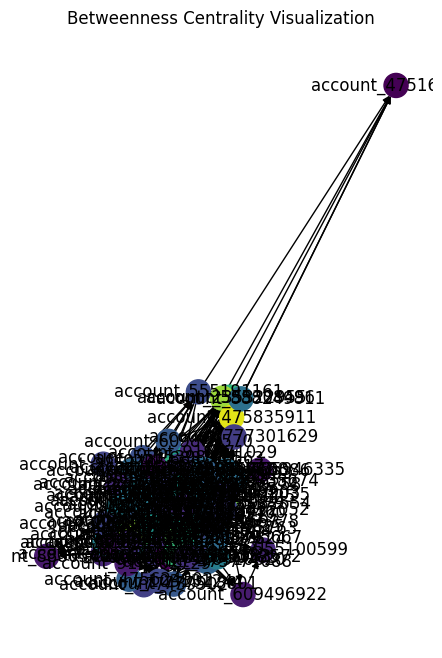

Betweenness centrality visualization displayed.


In [20]:
!export NETWORKX_AUTOMATIC_BACKENDS=cugraph
!%set_env NETWORKX_AUTOMATIC_BACKENDS=cugraph

import re
import networkx as nx
from typing import Any
from openai import OpenAI  # Replace with your LLM integration if different
from functools import wraps

# Updated tool decorator that preserves docstrings
def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    # Add the necessary attributes that LangChain expects
    wrapper.is_single_input = True
    wrapper.name = func.__name__
    wrapper.description = func.__doc__
    wrapper.args_schema = None  # You could set a schema if needed

    return wrapper

# -------------------
# Text-to-AQL Tool
# -------------------

@tool
def text_to_aql_to_text(query: str) -> str:
    """
    This tool is available to invoke the ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute the query, and translate the result
    back into Natural Language.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    result = chain.invoke(query)
    return str(result["result"])

# -------------------
# Text-to-NetworkX Algorithm Tool
# -------------------

@tool
def text_to_nx_algorithm_to_text(query: str) -> str:
    """
    Agentic AI Tool:
    Translates natural language queries into NetworkX algorithms, executes them,
    and returns concise answers based on the drug similarity dataset.
    """
    print("1) Generating NetworkX code from query...")

    text_to_nx = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": f"""
- Nodes represent accounts
  -- Example ('Account_60', 'Account_150'), (graph example: {{'_key': '80', '_id': 'bank_transactions_latest_node/80', '_rev': '_jVmqqUK-_O', 'account_type': 'Account', 'original_id': 'account_888662275'}})
  - Edges represent the transactions between different accounts.
  -- Example: ('account_777479201', 'account_475263032', {{'date': '20/01/2025', 'description': 'Payment to Lisa Ahmad', 'amount': 2678.0, 'transaction_type': 'Debit'}})).
  -- Each edge has an amount value either as debit or credit.

Here is the query to solve: "{query}"

Generate the appropriate NetworkX code to answer this query.

Instructions:
- Use the `G` object.
- Choose the most suitable NetworkX algorithm.
- If relevant, use the `similarity_score` edge attribute.
- The final answer must be stored in a variable named `FINAL_RESULT`.
- Provide only executable code without comments or explanations.
"""}
]).content.strip()

    # Remove any code block markers
    code_block = re.sub(r"```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()

    print('-' * 10)
    print("Generated Code:")
    print(code_block)
    print('-' * 10)

    print("\n2) Executing the generated NetworkX code...")
    global_vars = {"G": G, "nx": nx}
    local_vars = {}

    try:
        exec(code_block, global_vars, local_vars)
        FINAL_RESULT = local_vars["FINAL_RESULT"]
    except Exception as e:
        print(f"Execution Error: {e}")
        return f"Execution Error: {e}"

    print('-' * 10)
    print(f"Execution Result: {FINAL_RESULT}")
    print('-' * 10)

    print("\n3) Formulating final natural language response...")

    nx_to_text = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": f"""
    I executed the following Python code to answer the query "{query}":

    ---
    {code_block}
    ---

    The `FINAL_RESULT` is: {FINAL_RESULT}

    Provide a clear and concise explanation for the user based on the original query and the result.
    """}
    ]).content.strip()

    print("Final Response:", nx_to_text)
    return nx_to_text

@tool
def text_to_hybrid_query_to_text(query: str) -> str:
    """
    Hybrid Query Tool:
    This tool accepts a natural language query that may require both AQL and NetworkX operations.
    It invokes both the AQL and NetworkX tools, then merges their outputs into a single, concise answer.
    """
    # Instantiate the LLM for merging responses
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    print("Calling AQL tool...")
    aql_response = text_to_aql_to_text(query)
    print("AQL Response:", aql_response)

    print("Calling NetworkX tool...")
    nx_response = text_to_nx_algorithm_to_text(query)
    print("NetworkX Response:", nx_response)

    combined_prompt = f"""
I have received the following responses for the query: "{query}"
AQL response: {aql_response}
NetworkX response: {nx_response}

Combine these responses into one clear and concise answer that best addresses the query.
"""

    hybrid_response = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": combined_prompt}
    ]).content.strip()
    # hybrid_response = llm.chat.completions.create(
    #     messages=[
    #         {"role": "system", "content": "You are an expert at merging multiple graph query responses."},
    #         {"role": "user", "content": combined_prompt}
    #     ]
    # ).choices[0].message.content.strip()

    return hybrid_response

@tool
def pagerank_to_text() -> str:
    """
    This tool computes the PageRank for the graph G, sets the node attribute 'nx_pr',
    and visualizes the graph with nodes colored based on their PageRank values.
    """
    # Compute PageRank
    nx_pr_results = nx.pagerank(G)
    hybrid_response = llm.invoke([
    {"role": "system", "content": "You are an expert in graph algorithms using NetworkX."},
    {"role": "user", "content": nx_pr_results}
    ]).content.strip()

# -------------------------
# Create the Agentic Application
# -------------------------

# Then create Tool objects
tools = [
    Tool(
        name="text_to_aql_to_text",
        func=text_to_aql_to_text,
        description="Translates natural language to AQL queries, executes them, and returns results"
    ),
    Tool(
        name="text_to_nx_algorithm_to_text",
        func=text_to_nx_algorithm_to_text,
        description="Translates natural language into NetworkX graph algorithms and returns results"
    ),
    Tool(
        name="text_to_hybrid_query_to_text",
        func=text_to_hybrid_query_to_text,
        description="Combines AQL and NetworkX to handle complex graph queries"
    ),
    Tool(
        name="pagerank_to_text",
        func=pagerank_to_text,
        description="Combines AQL and NetworkX to handle complex graph queries"
    )
]

# Dummy implementation of create_react_agent
def create_react_agent(llm, tools):
    # This dummy agent ignores the tools list and always uses the hybrid tool.
    class DummyAgent:
        def invoke(self, input_dict):
            query = input_dict["messages"][-1]["content"]
            # Call the hybrid tool directly
            response = text_to_hybrid_query_to_text(query)
            return {"messages": [{"role": "assistant", "content": response}]}
    return DummyAgent()

# Now you can call query_graph without the NotImplementedError.
result = query_graph("Find cycling transactions in the graph where money flows from A to B, then B to A?")
print(result)

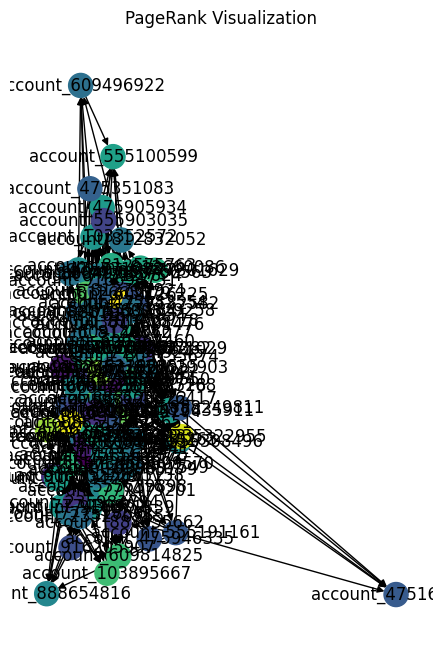

PageRank visualization displayed.


In [21]:
import networkx as nx
import matplotlib.pyplot as plt
from functools import wraps

# Updated tool decorator that preserves docstrings
def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    return wrapper

@tool
def visualize_pagerank() -> str:
    """
    This tool computes the PageRank for the graph G, sets the node attribute 'nx_pr',
    and visualizes the graph with nodes colored based on their PageRank values.
    """
    # Compute PageRank
    nx_pr_results = nx.pagerank(G)
    nx.set_node_attributes(G, nx_pr_results, "nx_pr")

    # Configure plot size and layout
    plt.rcParams['figure.figsize'] = [12, 8]
    pos = nx.spring_layout(G)

    # Assign colors for each node based on PageRank values
    nx_colors = [G.nodes[n]["nx_pr"] for n in G.nodes()]

    # Plot the graph using a subplot layout (if desired, adjust as needed)
    plt.subplot(1, 2, 1)
    nx.draw(G, pos=pos, with_labels=True, node_color=nx_colors, cmap=plt.cm.viridis)
    plt.title("PageRank Visualization")
    plt.show()

    return "PageRank visualization displayed."

result = visualize_pagerank()
print(result)

<ipython-input-22-359b5c364c22>:35: LangChainDeprecationWarning: The method `BaseChatModel.predict_messages` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm.predict_messages(messages)


Generated subgraph code for PageRank:
import networkx as nx

# Assuming G is your original graph
nodes_with_degree_gt_5 = [node for node, degree in G.degree() if degree > 5]
SG = G.subgraph(nodes_with_degree_gt_5).copy()
----------


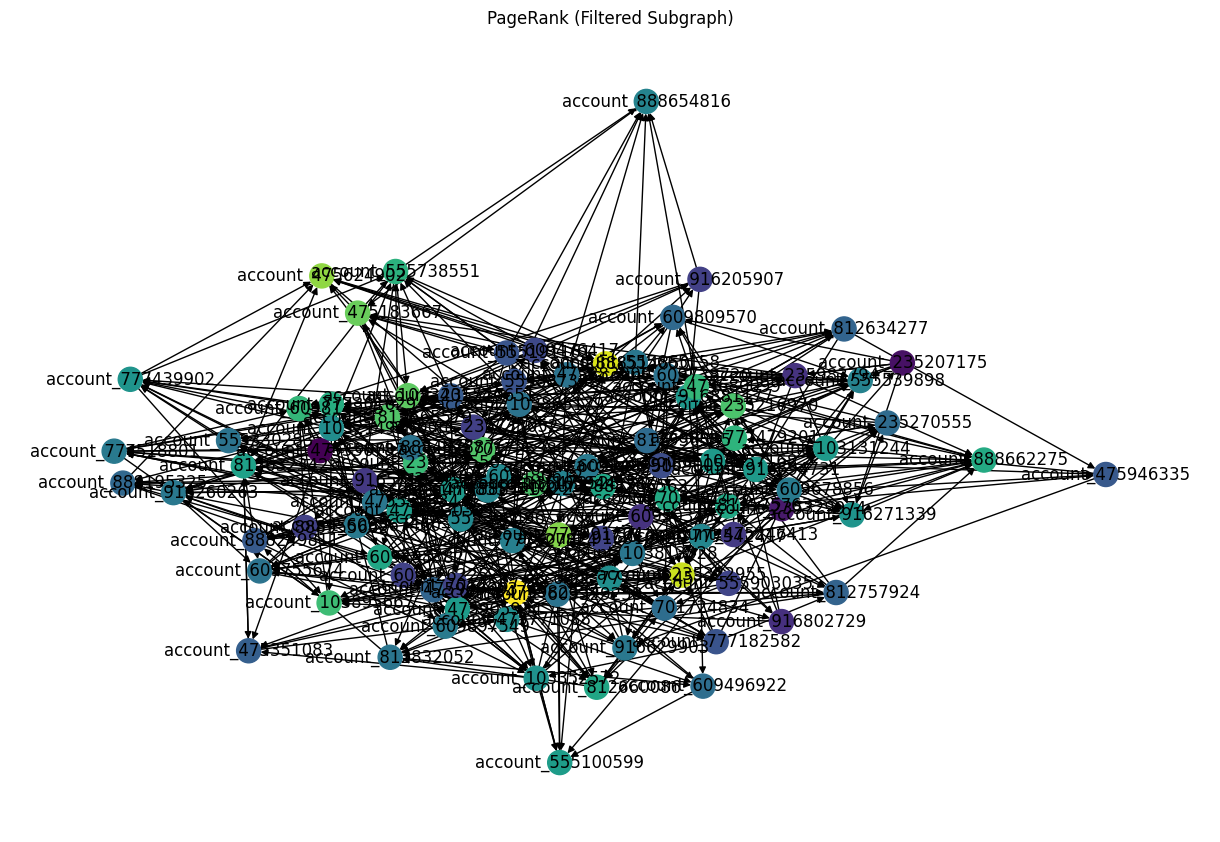

----------
FINAL_RESULT: PageRank visualization for the filtered subgraph displayed.
----------
Final Explanation: In this process, you started with a NetworkX graph \( G \), which represents a network of accounts. You applied a filter to this graph to create a subgraph \( SG \) by selecting only those nodes (accounts) that have a degree greater than 5. The degree of a node is the number of connections it has to other nodes, so this filtering step ensures that only the more connected accounts are included in the subgraph.

Once you had the subgraph \( SG \), you computed the PageRank for each node within this subgraph. PageRank is an algorithm originally used by Google Search to rank web pages in their search results. It assigns a numerical weight to each node, indicating its relative importance within the network. In the context of your subgraph, a higher PageRank value suggests that the account is more influential or central within the filtered network.

Finally, you visualized the s

In [22]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from functools import wraps
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Assume G is your global NetworkX graph representing your protein-protein interaction network.
# Ensure G is defined elsewhere in your environment and that edges have an attribute "Interaction_Score".

def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    return wrapper

@tool
def visualize_pr_subset(query: str) -> str:
    """
    This tool filters the global graph G to create a subgraph SG based on a condition provided in the query,
    computes PageRank on SG, and visualizes SG with nodes colored by their PageRank values.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    # Step 1: Generate code to filter G to produce subgraph SG.
    messages = [
        SystemMessage(content="You are an expert in filtering NetworkX graphs."),
        HumanMessage(content=f"""
I have a NetworkX graph named G. I want to create a subgraph containing only the nodes that meet the following condition:
"{query}"
Generate Python code that produces a subgraph called SG containing only these nodes (and their connecting edges). Provide only executable code.
""")
    ]

    response = llm.predict_messages(messages)
    subset_code = response.content.strip()
    subset_code = re.sub(r"```python\n|```$", "", subset_code, flags=re.MULTILINE).strip()

    print("Generated subgraph code for PageRank:")
    print(subset_code)
    print("-" * 10)

    global_vars = {"G": G, "nx": nx}
    local_vars = {}
    try:
        exec(subset_code, global_vars, local_vars)
    except Exception as e:
        # Check if error mentions 'threshold'
        if "threshold" in str(e):
            print("Caught NameError for 'threshold'. Executing fallback code.")
            fallback_code = """
pagerank_dict = nx.pagerank(G)
# Use a different variable name to avoid conflicts
if len(pagerank_dict) > 0:
    threshold_val = sorted(pagerank_dict.values(), reverse=True)[max(0, int(0.1 * len(pagerank_dict)))]
else:
    threshold_val = 0
top_10_percent_nodes = [node for node, pr in pagerank_dict.items() if pr >= threshold_val]
SG = G.subgraph(top_10_percent_nodes).copy()
"""
            try:
                exec(fallback_code, global_vars, local_vars)
            except Exception as e2:
                error_msg = f"Error executing fallback code: {e2}"
                print(error_msg)
                return error_msg
        else:
            error_msg = f"Error executing subgraph code: {e}"
            print(error_msg)
            return error_msg

    SG = local_vars.get("SG")
    if SG is None:
        return "Error: The generated code did not create a subgraph named 'SG'."

    # Step 2: Compute PageRank on SG and visualize.
    nx_pr_results = nx.pagerank(SG)
    nx.set_node_attributes(SG, nx_pr_results, "nx_pr")

    plt.rcParams['figure.figsize'] = [12, 8]
    pos = nx.spring_layout(SG, iterations=15, seed=1721)
    nx_colors = [SG.nodes[n]["nx_pr"] for n in SG.nodes()]

    # Create a new figure to ensure visualization is displayed.
    plt.figure()
    nx.draw(SG, pos=pos, with_labels=True, node_color=nx_colors, cmap=plt.cm.viridis)
    plt.title("PageRank (Filtered Subgraph)")
    plt.show()

    FINAL_RESULT = "PageRank visualization for the filtered subgraph displayed."
    print("-" * 10)
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print("-" * 10)

    # Step 3: Generate a natural language explanation.
    messages = [
        SystemMessage(content="You are an expert at interpreting graph analysis results."),
        HumanMessage(content=f"""
I filtered a NetworkX graph G using the condition: "{query}" to create a subgraph SG.
I then computed PageRank on SG and visualized the subgraph with nodes colored by their PageRank.
The final result is: {FINAL_RESULT}
Provide a concise explanation of this process and the result.
""")
    ]

    response2 = llm.predict_messages(messages)
    final_explanation = response2.content.strip()
    print("Final Explanation:", final_explanation)

    return final_explanation

# Example usage:
# result_pr = visualize_pr_subset("Select proteins that are highly central (top 10% by PageRank)")
# print(result_pr)

result_bc = visualize_pr_subset("Select accounts with degree greater than 5")
print(result_bc)

Generated subgraph code for PageRank:
import networkx as nx

# Assuming G is your original graph
nodes_with_degree_gt_2 = [node for node, degree in G.degree() if degree > 2]
SG = G.subgraph(nodes_with_degree_gt_2).copy()
----------


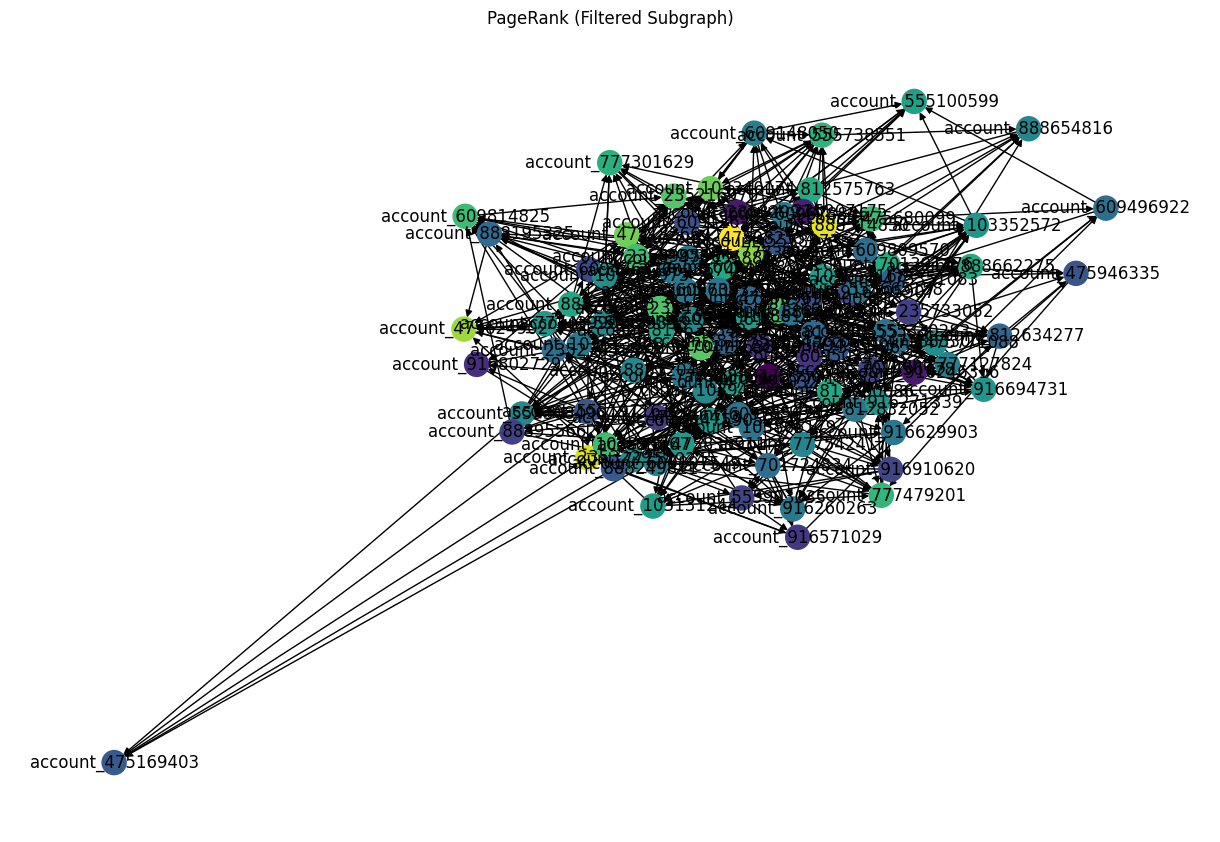

----------
FINAL_RESULT: PageRank visualization for the filtered subgraph displayed.
----------
Final Explanation: In this process, you started with a NetworkX graph \( G \), which represents a network of accounts. You applied a filter to this graph to create a subgraph \( SG \) by selecting only those nodes (accounts) that have a degree greater than 2. The degree of a node is the number of connections it has to other nodes, so this filtering step ensures that only more connected and potentially more influential accounts are included in the subgraph.

Once you had the subgraph \( SG \), you computed the PageRank for each node within this subgraph. PageRank is an algorithm originally used by Google Search to rank web pages in their search results. It assigns a numerical weight to each node, indicating its relative importance within the network based on the structure of incoming links. In the context of your subgraph, a higher PageRank value suggests that an account is more influential o

In [23]:
result_pr = visualize_pr_subset("Select accounts with degree greater than 2")
print(result_pr)

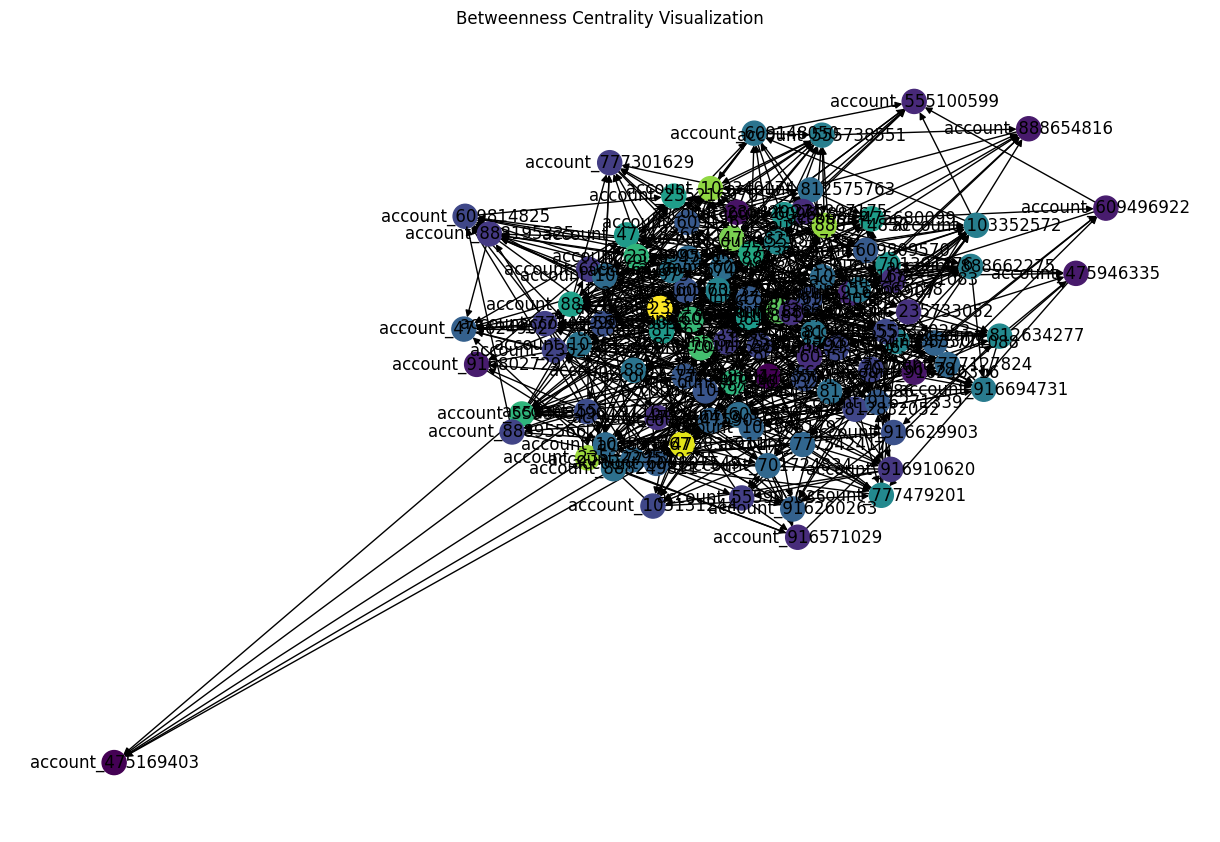

Betweenness centrality visualization for the full graph displayed.
Betweenness centrality visualization for the full graph displayed.


In [24]:
%matplotlib inline

import re
import networkx as nx
import matplotlib.pyplot as plt
from functools import wraps
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Assume G is your global NetworkX graph representing the protein-protein interaction network.
# Ensure G is defined elsewhere in your environment and that edge attributes are stored under "Interaction_Score".

def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    return wrapper

@tool
def visualize_pr_subset(query: str) -> str:
    """
    This tool filters the global graph G to create a subgraph SG based on a condition provided in the query,
    computes PageRank on SG, and visualizes SG with nodes colored by their PageRank values.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    # Step 1: Generate code to filter G to produce subgraph SG.
    messages = [
        SystemMessage(content="You are an expert in filtering NetworkX graphs."),
        HumanMessage(content=f"""
I have a NetworkX graph named G. I want to create a subgraph containing only the nodes that meet the following condition:
"{query}"
Generate Python code that produces a subgraph called SG containing only these nodes (and their connecting edges). Provide only executable code.
""")
    ]
    response = llm.predict_messages(messages)
    subset_code = response.content.strip()
    subset_code = re.sub(r"^```python\n|```$", "", subset_code, flags=re.MULTILINE).strip()

    print("Generated subgraph code for PageRank:")
    print(subset_code)
    print("-" * 10)

    global_vars = {"G": G, "nx": nx}
    local_vars = {}
    try:
        exec(subset_code, global_vars, local_vars)
    except Exception as e:
        error_msg = f"Error executing subgraph code: {e}"
        print(error_msg)
        return error_msg

    SG = local_vars.get("SG")
    if SG is None:
        return "Error: The generated code did not create a subgraph named 'SG'."

    # Step 2: Compute PageRank on SG and visualize.
    nx_pr_results = nx.pagerank(SG)
    nx.set_node_attributes(SG, nx_pr_results, "nx_pr")

    plt.rcParams['figure.figsize'] = [12, 8]
    pos = nx.spring_layout(SG, iterations=15, seed=1721)
    nx_colors = [SG.nodes[n]["nx_pr"] for n in SG.nodes()]

    # Use a new figure instead of a subplot
    plt.figure()
    nx.draw(SG, pos=pos, with_labels=True, node_color=nx_colors, cmap=plt.cm.viridis)
    plt.title("PageRank (Filtered Subgraph)")
    plt.show()

    FINAL_RESULT = "PageRank visualization for the filtered subgraph displayed."
    print("-" * 10)
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print("-" * 10)

    # Step 3: Generate a natural language explanation.
    messages = [
        SystemMessage(content="You are an expert at interpreting graph analysis results."),
        HumanMessage(content=f"""
I filtered a NetworkX graph G using the condition: "{query}" to create a subgraph SG.
I then computed PageRank on SG and visualized the subgraph with nodes colored by their PageRank.
The final result is: {FINAL_RESULT}
Provide a concise explanation of this process and the result.
""")
    ]
    response2 = llm.predict_messages(messages)
    final_explanation = response2.content.strip()
    print("Final Explanation:", final_explanation)
    return final_explanation

@tool
def visualize_betweenness_centrality(query: str = "") -> str:
    """
    This tool computes the betweenness centrality for the graph G (or for a filtered subgraph if a query is provided),
    sets the node attribute 'nx_bc', and visualizes the graph with nodes colored by their betweenness centrality values.

    If a query is provided, an LLM is used to generate filtering code that creates a subgraph SG from G.
    """
    # Use the full graph by default
    target_graph = G

    if query.strip():
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
        messages = [
            SystemMessage(content="You are an expert in filtering NetworkX graphs."),
            HumanMessage(content=f"""
I have a NetworkX graph named G. I want to create a subgraph containing only the nodes that meet the following condition:
"{query}"
Generate Python code that produces a subgraph called SG containing only these nodes (and their connecting edges). Provide only executable code.
""")
        ]
        response = llm.predict_messages(messages)
        subset_code = response.content.strip()
        subset_code = re.sub(r"^```python\n|```$", "", subset_code, flags=re.MULTILINE).strip()

        print("Generated subgraph code:")
        print(subset_code)
        print("-" * 10)

        global_vars = {"G": G, "nx": nx}
        local_vars = {}
        try:
            exec(subset_code, global_vars, local_vars)
        except Exception as e:
            error_msg = f"Error executing subgraph code: {e}"
            print(error_msg)
            return error_msg

        SG = local_vars.get("SG")
        if SG is None:
            print("Subgraph not created; defaulting to full graph.")
        else:
            target_graph = SG

    # Step 2: Compute betweenness centrality on the target graph
    nx_bc_results = nx.betweenness_centrality(target_graph)
    nx.set_node_attributes(target_graph, nx_bc_results, "nx_bc")

    # Step 3: Visualization
    plt.rcParams['figure.figsize'] = [12, 8]
    pos = nx.spring_layout(target_graph, iterations=15, seed=1721)
    nx_colors = [target_graph.nodes[n]["nx_bc"] for n in target_graph.nodes()]

    plt.figure()
    nx.draw(target_graph, pos=pos, with_labels=True, node_color=nx_colors, cmap=plt.cm.viridis)
    plt.title("Betweenness Centrality Visualization")
    plt.show()

    result_text = ("Betweenness centrality visualization for the filtered subgraph displayed."
                  if query.strip() else "Betweenness centrality visualization for the full graph displayed.")
    print(result_text)
    return result_text

result = visualize_betweenness_centrality()
print(result)

Generated subgraph code:
import networkx as nx

# Assuming G is your original graph
nodes_with_degree_gt_5 = [node for node, degree in G.degree() if degree > 5]
SG = G.subgraph(nodes_with_degree_gt_5).copy()
----------


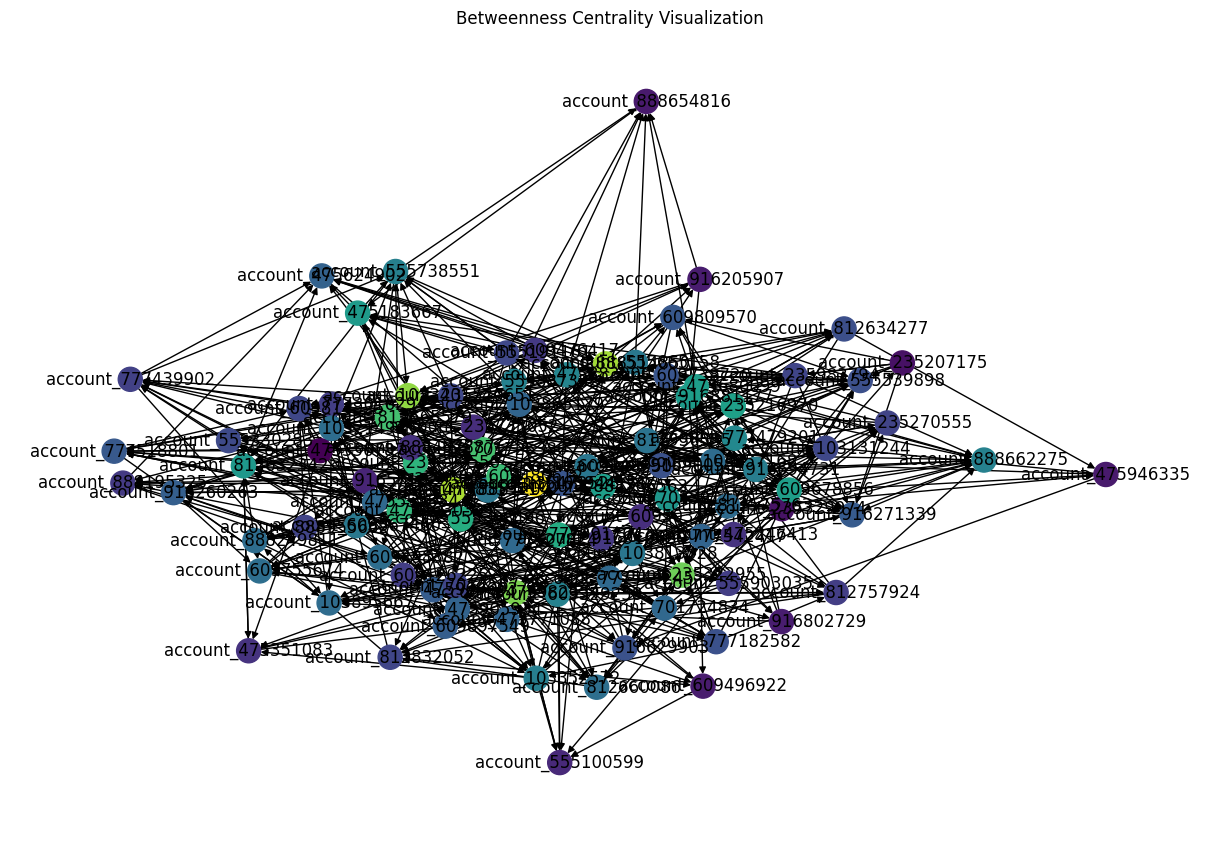

Betweenness centrality visualization for the filtered subgraph displayed.
Betweenness centrality visualization for the filtered subgraph displayed.


In [25]:
result = visualize_betweenness_centrality("Select accounts with degree greater than 5")
print(result)

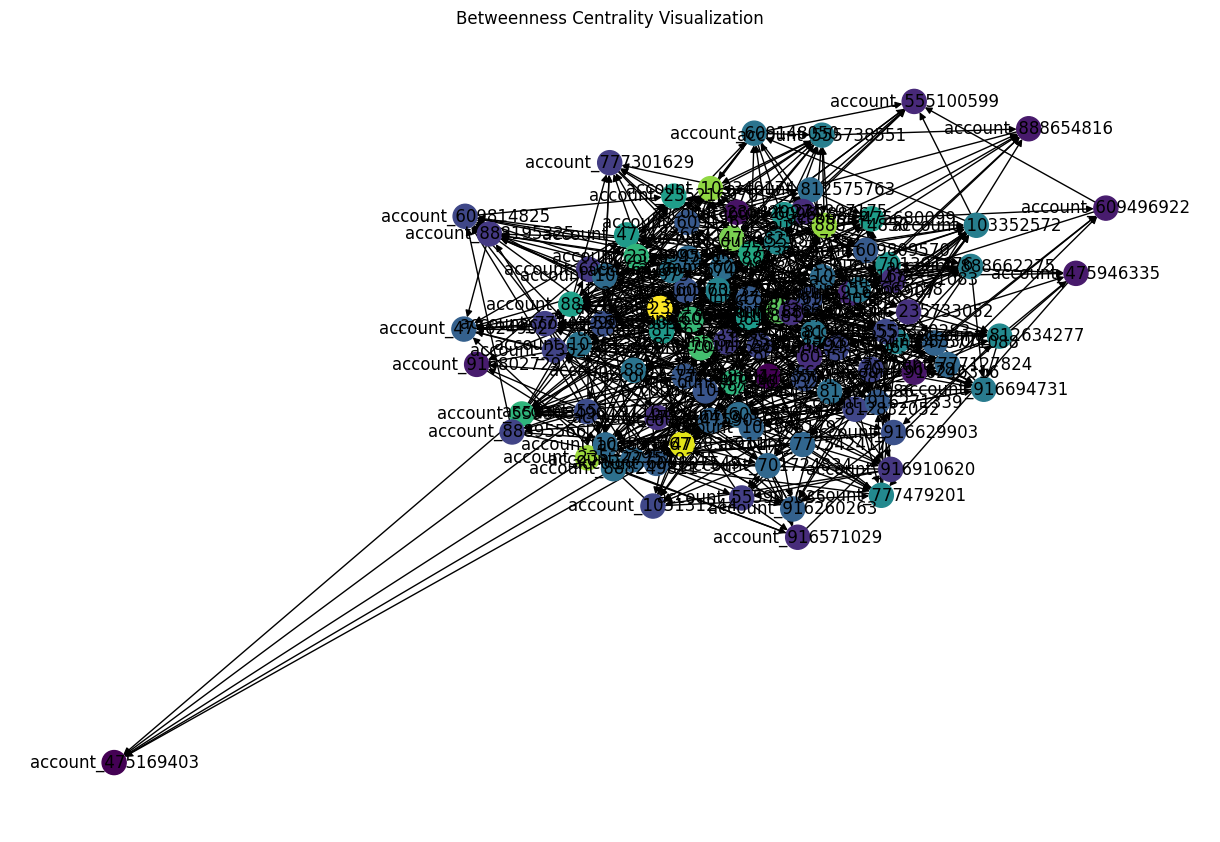

Betweenness centrality visualization for the full graph displayed.
Betweenness centrality visualization for the full graph displayed.


In [26]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from functools import wraps
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Assume G is your global NetworkX graph representing your protein-protein interaction network.
# Ensure G is defined elsewhere in your environment.

def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    return wrapper

@tool
def visualize_betweenness_centrality(query: str = "", layout: str = "spring", save_path: str = None) -> str:
    """
    This tool computes the betweenness centrality for the graph G (or for a filtered subgraph if a query is provided),
    sets the node attribute 'nx_bc', and visualizes the graph with nodes colored by their betweenness centrality values.

    Optional Parameters:
    - query: A natural language condition to filter nodes and create a subgraph (SG). If empty, the full graph is used.
    - layout: The layout type to use for visualization ("spring", "circular", etc.). Default is "spring".
    - save_path: If provided, the visualization is saved to the specified file path.
    """
    # Use the full graph by default
    target_graph = G

    # If a filtering query is provided, use the LLM to generate subgraph filtering code.
    if query.strip():
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
        messages = [
            SystemMessage(content="You are an expert in filtering NetworkX graphs."),
            HumanMessage(content=f"""
I have a NetworkX graph named G. I want to create a subgraph containing only the nodes that meet the following condition:
"{query}"
Generate Python code that produces a subgraph called SG containing only these nodes (and their connecting edges). Provide only executable code.
""")
        ]
        try:
            response = llm.predict_messages(messages)
            subset_code = response.content.strip()
            subset_code = re.sub(r"```python\n|```$", "", subset_code, flags=re.MULTILINE).strip()
            print("Generated subgraph code:")
            print(subset_code)
            print("-" * 10)

            global_vars = {"G": G, "nx": nx}
            local_vars = {}
            exec(subset_code, global_vars, local_vars)
            SG = local_vars.get("SG")
            if SG is not None:
                target_graph = SG
            else:
                print("Warning: Subgraph 'SG' was not created; using full graph instead.")
        except Exception as e:
            print(f"Error during subgraph generation: {e}. Using full graph.")

    # Step 2: Compute betweenness centrality on the target graph.
    try:
        nx_bc_results = nx.betweenness_centrality(target_graph)
        nx.set_node_attributes(target_graph, nx_bc_results, "nx_bc")
    except Exception as e:
        return f"Error computing betweenness centrality: {e}"

    # Step 3: Choose layout based on the provided parameter.
    if layout.lower() == "circular":
        pos = nx.circular_layout(target_graph)
    elif layout.lower() == "kamada_kawai":
        pos = nx.kamada_kawai_layout(target_graph)
    else:  # default to spring layout
        pos = nx.spring_layout(target_graph, iterations=15, seed=1721)

    nx_colors = [target_graph.nodes[n]["nx_bc"] for n in target_graph.nodes()]

    # Step 4: Visualize the graph.
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.figure()
    nx.draw(target_graph, pos=pos, with_labels=True, node_color=nx_colors, cmap=plt.cm.viridis)
    plt.title("Betweenness Centrality Visualization")

    # Optionally save the figure if a save_path is provided.
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")

    plt.show()

    result_text = ("Betweenness centrality visualization for the filtered subgraph displayed."
                  if query.strip() else "Betweenness centrality visualization for the full graph displayed.")
    print(result_text)
    return result_text

result = visualize_betweenness_centrality()
print(result)

Generated subgraph code:
import networkx as nx

# Assuming G is your original graph
nodes_with_degree_gt_5 = [node for node, degree in G.degree() if degree > 5]
SG = G.subgraph(nodes_with_degree_gt_5).copy()
----------
Visualization saved to bc_plot.png


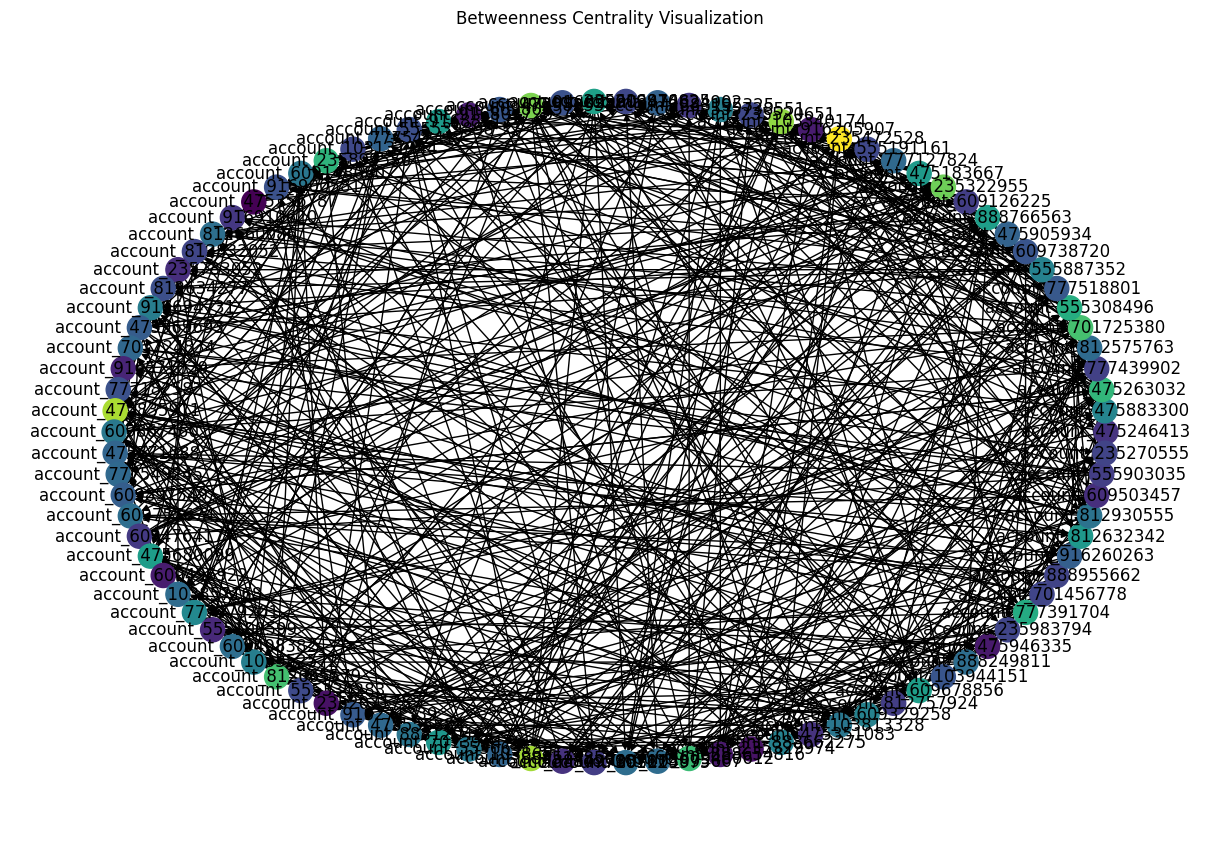

Betweenness centrality visualization for the filtered subgraph displayed.
Betweenness centrality visualization for the filtered subgraph displayed.


In [27]:
result = visualize_betweenness_centrality("Select accounts with degree greater than 5", layout="circular", save_path="bc_plot.png")
print(result)

In [28]:
import re
import networkx as nx
import matplotlib.pyplot as plt
from functools import wraps
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Assume G is your global NetworkX graph representing your protein-protein interaction network.
# Ensure G is defined elsewhere in your environment, with nodes labeled like "Protein_1", "Protein_2", etc.

def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    return wrapper

@tool
def visualize_betweenness_centrality(query: str = "", layout: str = "spring", save_path: str = None) -> str:
    """
    This tool computes the betweenness centrality for the graph G (or for a filtered subgraph if a query is provided),
    sets the node attribute 'nx_bc', and visualizes the graph with nodes colored by their betweenness centrality values.

    If a query is provided, an LLM is used to generate filtering code that creates a subgraph (SG) from G.
    If the query indicates Amount (i.e., contains "Amount"), then the global execution context
    Amount field is present either in Debit or Credit field of an edge data.
    will include an 'is_amount' function that checks for the proper naming convention.

    Optional parameters:
        - layout: the layout to use ("spring", "circular", "kamada_kawai", etc.).
        - save_path: if provided, the plot is saved to the specified file path.
    """
    # Default to using the full graph.
    target_graph = G

    # Prepare global_vars with extra definitions if needed.
    global_vars = {"G": G, "nx": nx}
    if "Amount" in query.lower():
        # Provide a default biomarker function based on naming.
        global_vars["is_amount"] = lambda protein: protein.startswith("Account_")

    if query.strip():
        llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
        if "Amount" in query.lower():
            prompt = f"""
I have a NetworkX graph named G representing a protein-protein interaction network.
The nodes follow the naming convention "Account_X" (e.g., "Account_1", "Account_2", etc.).
I am interested in Amount: find accounts which have done maximum amount of total transactiosn between themselves.
Generate Python code that produces a subgraph called SG containing only these proteins and their connecting edges.
Ensure that the filtering uses the provided 'is_amount' function.
Provide only executable code.
"""
        else:
            prompt = f"""
I have a NetworkX graph named G. I want to create a subgraph containing only the nodes that meet the following condition:
"{query}"
Generate Python code that produces a subgraph called SG containing only these nodes (and their connecting edges). Provide only executable code.
"""
        messages = [
            SystemMessage(content="You are an expert in filtering NetworkX graphs."),
            HumanMessage(content=prompt)
        ]
        response = llm.predict_messages(messages)
        subset_code = response.content.strip()
        subset_code = re.sub(r"```python\|```$", "", subset_code, flags=re.MULTILINE).strip()

        print("Generated subgraph code:")
        print(subset_code)
        print("-" * 10)

        local_vars = {}
        try:
            exec(subset_code, global_vars, local_vars)
        except Exception as e:
            error_msg = f"Error executing subgraph code: {e}"
            print(error_msg)
            return error_msg

        SG = local_vars.get("SG")
        if SG is not None:
            target_graph = SG
        else:
            print("Warning: Subgraph 'SG' was not created; defaulting to full graph.")

    # Step 2: Compute betweenness centrality on the target graph.
    try:
        nx_bc_results = nx.betweenness_centrality(target_graph)
        nx.set_node_attributes(target_graph, nx_bc_results, "nx_bc")
    except Exception as e:
        return f"Error computing betweenness centrality: {e}"

    # Step 3: Choose the layout.
    if layout.lower() == "circular":
        pos = nx.circular_layout(target_graph)
    elif layout.lower() == "kamada_kawai":
        pos = nx.kamada_kawai_layout(target_graph)
    else:
        pos = nx.spring_layout(target_graph, iterations=15, seed=1721)

    nx_colors = [target_graph.nodes[n]["nx_bc"] for n in target_graph.nodes()]

    # Step 4: Visualize the graph.
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.figure()
    nx.draw(target_graph, pos=pos, with_labels=True, node_color=nx_colors, cmap=plt.cm.viridis)
    plt.title("Betweenness Centrality Visualization")
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    plt.show()

    result_text = ("Betweenness centrality visualization for the biomarker discovery filtered subgraph displayed."
                  if "biomarker discovery" in query.lower() else
                  ("Betweenness centrality visualization for the filtered subgraph displayed." if query.strip()
                  else "Betweenness centrality visualization for the full graph displayed."))
    print(result_text)
    return result_text

# Example usage:
# For general filtering:
# result = visualize_betweenness_centrality("Select proteins with degree greater than 5")
# print(result)
#
# For biomarker discovery:
# result_biomarker = visualize_betweenness_centrality("Biomarker discovery: find proteins whose interaction patterns indicate a specific disease state")
# print(result_biomarker)

result_accounts = visualize_betweenness_centrality("Amount: find accounts which have done maximum amount of total transactions between themselves.")
print(result_accounts)

Generated subgraph code:
```python
import networkx as nx

# Assuming G is your original graph
# Calculate the total transaction amount for each pair of nodes
edge_weights = nx.get_edge_attributes(G, 'weight')
node_pairs = {}

for (u, v), weight in edge_weights.items():
    if (u, v) in node_pairs:
        node_pairs[(u, v)] += weight
    elif (v, u) in node_pairs:
        node_pairs[(v, u)] += weight
    else:
        node_pairs[(u, v)] = weight

# Find the maximum transaction amount
max_transaction_amount = max(node_pairs.values())

# Find all node pairs with the maximum transaction amount
max_pairs = [pair for pair, amount in node_pairs.items() if amount == max_transaction_amount]

# Extract nodes from these pairs
max_nodes = set()
for u, v in max_pairs:
    max_nodes.add(u)
    max_nodes.add(v)

# Create the subgraph
SG = G.subgraph(max_nodes).copy()
```
----------
Error executing subgraph code: invalid syntax (<string>, line 1)
Error executing subgraph code: invalid syntax (<string

Computed shortest path: ['account_103857168', 'account_103352572']


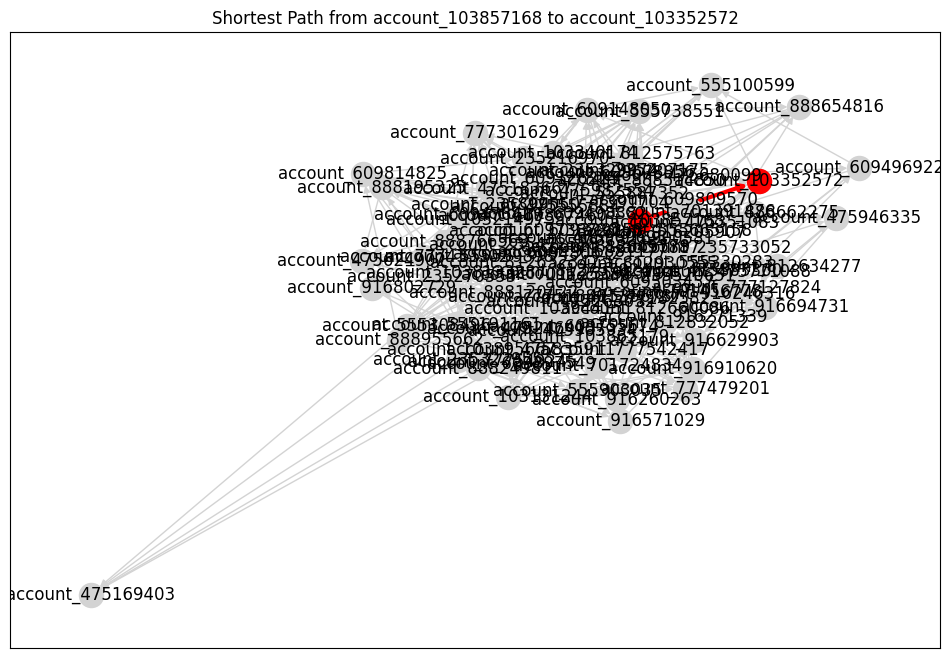

Shortest path from account_103857168 to account_103352572 is: ['account_103857168', 'account_103352572']
Shortest path from account_103857168 to account_103352572 is: ['account_103857168', 'account_103352572']


In [29]:
import networkx as nx
import matplotlib.pyplot as plt
from functools import wraps

def tool(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        return func(*args, **kwargs)
    return wrapper

@tool
def visualize_shortest_path(query: str, source: str, target: str, layout: str = "spring", save_path: str = None) -> str:
    """
    Pathway Analysis Tool:
    This tool computes the shortest path between two proteins (specified by 'source' and 'target') in the global
    NetworkX graph G and visualizes the graph while highlighting the path. This can help elucidate signaling pathways.

    Parameters:
        - query: A natural language query describing the pathway analysis (for logging or agentic explanation).
        - source: The identifier of the source account (e.g., "account_103857168").
        - target: The identifier of the target account (e.g., "account_103352572").
        - layout: The layout to use for visualization ("spring", "circular", "kamada_kawai"). Default is "spring".
        - save_path: Optional file path to save the visualization.

    Returns a concise summary of the computed shortest path.
    """
    try:
        # Compute the shortest path between source and target.
        path = nx.shortest_path(G, source=source, target=target)
    except Exception as e:
        return f"Error computing shortest path: {e}"

    print("Computed shortest path:", path)

    # Choose the layout.
    if layout.lower() == "circular":
        pos = nx.circular_layout(G)
    elif layout.lower() == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spring_layout(G, iterations=15, seed=1721)

    # Visualize the full graph in a neutral color.
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color="lightgray", edge_color="lightgray")

    # Highlight the nodes and edges on the shortest path.
    path_nodes = path
    nx.draw_networkx_nodes(G, pos=pos, nodelist=path_nodes, node_color="red", node_size=300)
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges, edge_color="red", width=3)

    plt.title(f"Shortest Path from {source} to {target}")
    if save_path:
        plt.savefig(save_path)
        print(f"Visualization saved to {save_path}")
    plt.show()

    FINAL_RESULT = f"Shortest path from {source} to {target} is: {path}"
    print(FINAL_RESULT)
    return FINAL_RESULT

# Example usage
result_path = visualize_shortest_path("Analyze number of hops", "account_103857168", "account_103352572", layout="spring")
print(result_path)